# Image Classification with Convolutional Neural Networks
Steps:

1.   Explore the Data of bikes and no bikes
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy or F1-score

## Libraries 

In [3]:
import pathlib
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

import numpy as np
import cv2

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Configure Environment

### Drive mount

In [4]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


### Get Data and Create Directory

In [5]:
%rm -r /tmp/*

!cp -r /drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/data_bike /tmp

### Define each of these directories.

In [6]:
base_dir = '/tmp/data_bike'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_bikes_dir = os.path.join(train_dir, 'bike')
train_nobikes_dir = os.path.join(train_dir, 'no_bike')

# Directory with our validation cat/dog pictures
validation_bikes_dir = os.path.join(validation_dir, 'bike')
validation_nobikes_dir = os.path.join(validation_dir, 'no_bike')

# Directory with our validation cat/dog pictures
test_bikes_dir = os.path.join(test_dir, 'bike')
test_nobikes_dir = os.path.join(test_dir, 'no_bike')

### Filenames look like in the `bikes` and `no_bikes` `train` directories.

In [7]:
train_bikes_fnames = os.listdir(train_bikes_dir)
train_nobikes_fnames = os.listdir(train_nobikes_dir)

print(train_bikes_fnames[:10])
print(train_nobikes_fnames[:10])

['bicicleta (808).jpg', 'bicicleta (681).jpg', 'bicicleta (1007).jpg', 'bicicleta (228).jpg', 'bicicleta (23).jpg', 'bicicleta (298).jpg', 'bicicleta (106).jpeg', 'bicicleta (236).jpg', 'bicicleta (60).jpg', 'bicicleta (421).jpg']
['00210.jpg', 'bicicletas_dibujo (237).jpg', 'moto (75).jpeg', 'moto (55).jpg', 'bicicletas_dibujo (270).jpg', '00252.jpg', 'moto (88).jpg', '00093.jpg', 'moto (46).jpeg', '00169.jpg']


### Total number of bikes and no bikes images in the `train` and `validation` directories.

In [8]:
print('total training bikes images :', len(os.listdir(train_bikes_dir)))
print('total training no_bikes images :', len(os.listdir(train_nobikes_dir)))

print('total validation bikes images :', len(os.listdir(validation_bikes_dir)))
print('total validation no_bikes images :', len(os.listdir(validation_nobikes_dir)))

print('total test bikes images :', len(os.listdir(test_bikes_dir)))
print('total test no_bikes images :', len(os.listdir(test_nobikes_dir)))

total training bikes images : 1421
total training no_bikes images : 1450
total validation bikes images : 381
total validation no_bikes images : 408
total test bikes images : 194
total test no_bikes images : 216


### Look at a few pictures to get a better sense of what the cat and dog datasets look like.

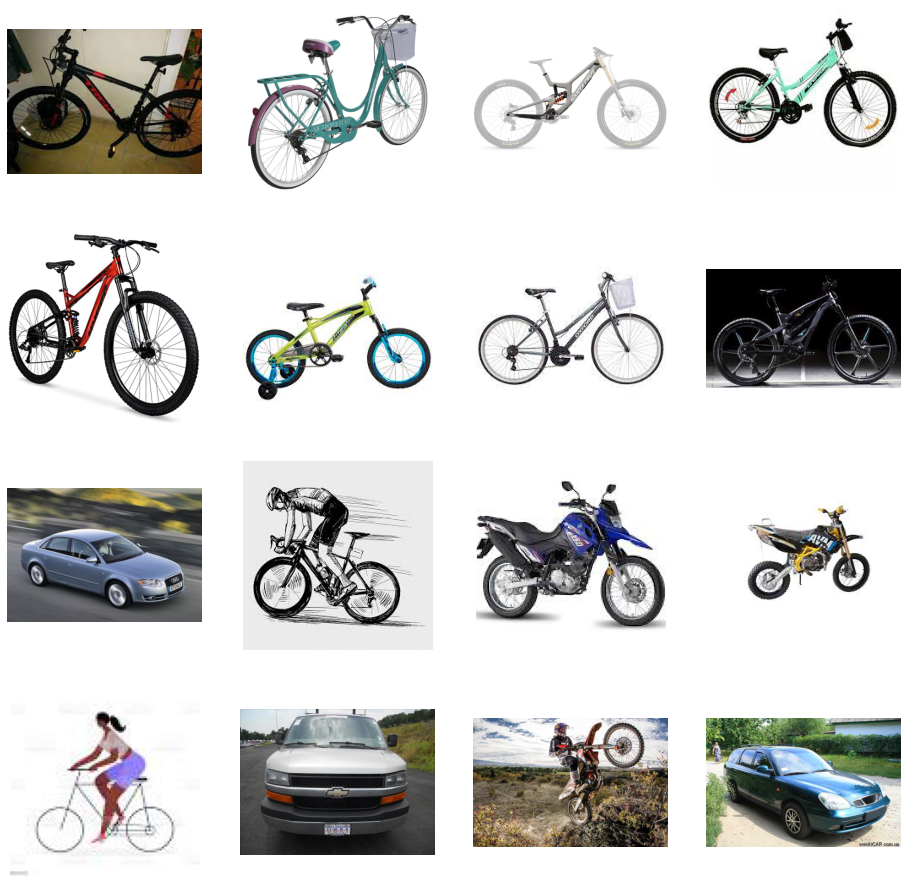

In [9]:
nrows = 4
ncols = 4

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_bike_pix = [os.path.join(train_bikes_dir, fname) 
                for fname in train_bikes_fnames[ pic_index-8:pic_index] 
               ]

next_nobike_pix = [os.path.join(train_nobikes_dir, fname) 
                for fname in train_nobikes_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_bike_pix + next_nobike_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(train_dir,
                                                                              target_size = (224, 224),
                                                                              batch_size = 20,
                                                                              class_mode = 'binary',
                                                                              seed = 16626)
                                     
val_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest').flow_from_directory(validation_dir,
                                                                            target_size = (224, 224),
                                                                            batch_size = 20,
                                                                            class_mode = 'binary',
                                                                            seed = 16626)
                                   
test_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest').flow_from_directory(test_dir,
                                                                            target_size = (224, 224),
                                                                            batch_size = 20,
                                                                            class_mode = 'binary',
                                                                            seed = 16626)                                 

Found 2855 images belonging to 2 classes.
Found 776 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [11]:
X_train, y_train = next(train_generator)                                  
X_val, y_val = next(val_generator)                                     
X_test, y_test = next(test_generator)

In [29]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2), 
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1024, activation='relu'), 
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(1, activation='sigmoid')  
                                    ])

In [30]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 43264)            

In [31]:
from tensorflow.keras.optimizers import RMSprop, Adam

model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [32]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    steps_per_epoch = 50,
                    epochs = 50,
                    validation_steps = 50,
                    verbose=2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/50 - 31s - loss: 0.7601 - accuracy: 0.5230 - val_loss: 0.6870 - val_accuracy: 0.5606
Epoch 2/50
50/50 - 18s - loss: 0.7011 - accuracy: 0.5350
Epoch 3/50
50/50 - 18s - loss: 0.6691 - accuracy: 0.5749
Epoch 4/50
50/50 - 19s - loss: 0.6585 - accuracy: 0.6120
Epoch 5/50
50/50 - 19s - loss: 0.6325 - accuracy: 0.6530
Epoch 6/50
50/50 - 18s - loss: 0.6250 - accuracy: 0.6820
Epoch 7/50
50/50 - 17s - loss: 0.5990 - accuracy: 0.6960
Epoch 8/50
50/50 - 18s - loss: 0.5567 - accuracy: 0.7380
Epoch 9/50
50/50 - 17s - loss: 0.5534 - accuracy: 0.7220
Epoch 10/50
50/50 - 18s - loss: 0.5126 - accuracy: 0.7680
Epoch 11/50
50/50 - 17s - loss: 0.5108 - accuracy: 0.7660
Epoch 12/50
50/50 - 18s - loss: 0.4983 - accuracy: 0.7670
Epoch 13/50
50/50 - 18s - loss: 0.4592 - accuracy: 0.8070
Epoch 14/50
50/50 - 18s - loss: 0.4779 - accuracy: 0.7809
Epoch 15/50
50/50 - 17s - loss: 0.4720 - accuracy: 0.7830
Epoch 16/50
50/50 - 17s - loss: 0.4556 - accuracy: 0.8010
Epoch 17/50
50/50 - 18s - loss: 0.4092 - accuracy:

In [36]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

In [50]:
history.history

{'accuracy': [0.5230000019073486,
  0.5350000262260437,
  0.5748744010925293,
  0.6119999885559082,
  0.652999997138977,
  0.6819999814033508,
  0.6959999799728394,
  0.7379999756813049,
  0.722000002861023,
  0.7680000066757202,
  0.765999972820282,
  0.7670000195503235,
  0.8069999814033508,
  0.7809045314788818,
  0.7829999923706055,
  0.8009999990463257,
  0.8180000185966492,
  0.8309999704360962,
  0.8100502490997314,
  0.8351758718490601,
  0.8241205811500549,
  0.828000009059906,
  0.8069999814033508,
  0.8360000252723694,
  0.8410000205039978,
  0.8502512574195862,
  0.7960000038146973,
  0.8140000104904175,
  0.8220000267028809,
  0.839195966720581,
  0.8402010202407837,
  0.8289999961853027,
  0.8482412099838257,
  0.843999981880188,
  0.8410000205039978,
  0.8460000157356262,
  0.8600000143051147,
  0.8271356821060181,
  0.8320000171661377,
  0.8412060141563416,
  0.8592965006828308,
  0.8402010202407837,
  0.8610000014305115,
  0.843216061592102,
  0.8339999914169312,
  0.8

ValueError: ignored

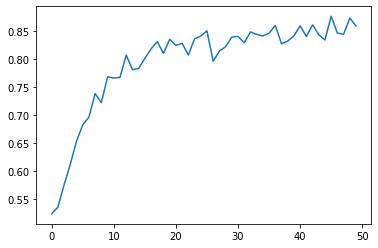

In [33]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title('Training and validation loss')

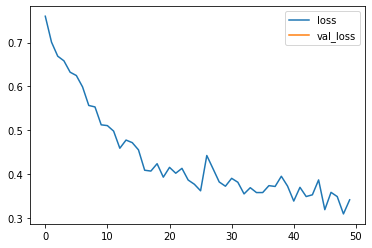

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

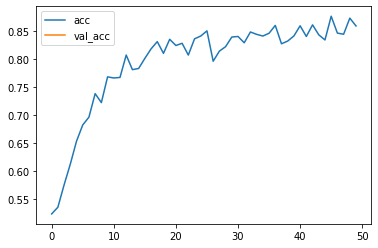

In [43]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [47]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(224, 224))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    classes = model.predict(images, batch_size=10)
    
    print(classes[0])
    
    if classes[0]>0:
        print(fn + " is a bike")
        
    else:
        print(fn + " not is a bike")

Saving bmw-768688_1920.jpg to bmw-768688_1920.jpg
[1.]
bmw-768688_1920.jpg is a bike


In [ ]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

# x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)